In [2]:
import pandas as pd

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [3]:
APP_NAME = "Survival Analysis with Deep Learning"

try:
    sc.stop()
    spark.stop()
except:
    pass

from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

try:
    sc and spark
except (NameError, UnboundLocalError) as e:
    import findspark
    #findspark.init()
    import pyspark
    import pyspark.sql
    
    #sc = pyspark.SparkContext()
    #spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    
sc = SparkContext(conf = SparkConf() .set("spark.driver.maxResultSize", "20g") .set("spark.sql.execution.arrow.enabled", "true") .set('spark.sql.broadcastTimeout', 1000) .set('spark.local.dir', '/data_data/session_length/spark_tmp/') .set('spark.driver.memory', '20G') .set("spark.executor.instances", "20") .set("spark.executor.cores", 20) .set("spark.executor.memory", "8G")).getOrCreate()
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")
    

In [5]:
sc._conf.getAll()

[(u'spark.local.dir', u'/data_data/session_length/spark_tmp/'),
 (u'spark.driver.port', u'38336'),
 (u'spark.driver.memory', u'20G'),
 (u'spark.sql.execution.arrow.enabled', u'true'),
 (u'spark.executor.cores', u'20'),
 (u'spark.executor.memory', u'8G'),
 (u'spark.executor.id', u'driver'),
 (u'spark.app.name', u'pyspark-shell'),
 (u'spark.executor.instances', u'20'),
 (u'spark.driver.maxResultSize', u'20g'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.driver.host', u'ip-172-31-41-62.ec2.internal'),
 (u'spark.app.id', u'local-1537981262764'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.master', u'local[*]'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.sql.broadcastTimeout', u'1000'),
 (u'spark.ui.showConsoleProgress', u'true')]

In [67]:
from pyspark.sql.types import StructField, StructType, StringType, LongType, DateType, DoubleType, IntegerType
from pyspark.sql.functions import count, mean, stddev_pop, min, max, lit, round, bround, pow, col, corr, lower, upper, avg, stddev, abs, log
from pyspark.sql.functions import lit, trim, rtrim, rpad, trim, coalesce
from pyspark.sql.functions import current_date, current_timestamp, date_add, date_sub, months_between, to_date
from pyspark.sql.functions import udf, col, countDistinct, lag
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, dense_rank, rank, expr

from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula, Bucketizer, QuantileDiscretizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier,NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.linalg import Vectors

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
!head /data_data/session_length/usersessions-jayashree.csv

In [8]:
!head /data_data/session_length/data/lastFM/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv

user_000001	2009-05-04T23:08:57Z	f1b1cf71-bd35-4e99-8624-24a6e15f133a	Deep Dish		Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
user_000001	2009-05-04T13:54:10Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Composition 0919 (Live_2009_4_15)
user_000001	2009-05-04T13:52:04Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Mc2 (Live_2009_4_15)
user_000001	2009-05-04T13:42:52Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Hibari (Live_2009_4_15)
user_000001	2009-05-04T13:42:11Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Mc1 (Live_2009_4_15)
user_000001	2009-05-04T13:38:31Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		To Stanford (Live_2009_4_15)
user_000001	2009-05-04T13:33:28Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Improvisation (Live_2009_4_15)
user_000001	2009-05-04T13:23:45Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Glacier (Live_2009_4_15)
user_000001	2009-05-04T13:19:22Z	a7f7df4a-77d8-4f12-8acd-5c60c93f4de8	坂本龍一		Parolibre (Live_2009_4_15)
user_000001	2009-05-04T13:13:38Z	a7f7df4a-77d8-4f12-8acd

In [8]:
user_sessions_df = None

In [9]:
def import_session_data():
    print("==================================================================================================================")
    print("========================================    IMPORTING USER SESSION DATA     ======================================")
    print("==================================================================================================================\n\n")
    global user_sessions_df
    sessionSchema = StructType([
        StructField('userid', StringType(), True),\
        StructField('gender', StringType(), True),\
        StructField('age', IntegerType(), True),\
        StructField('country', StringType(), True),\
        StructField('startdate', DateType(), True),\
        StructField('day_of_week', StringType(), True),\
        StructField('timeofday', StringType(), True),\
        StructField('sessionid', IntegerType(), True),\
        StructField('session_start', DateType(), True),\
        StructField('session_length', IntegerType(), True),\
        ])
    user_sessions_df = spark.read.format('csv').schema(sessionSchema).option('header',True).load('/data_data/session_length/usersessions-jayashree.csv')
    


In [10]:
import_session_data()

========================================    IMPORTING USER SESSION DATA     ======================================




In [11]:
user_sessions_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------+--------------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|session_start|session_length|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------+--------------+
|user_000001|     m|null|  Japan|2006-08-13|  sunday   |     noon|        1|   2006-08-13|           230|
|user_000001|     m|null|  Japan|2006-08-15|  tuesday  |  morning|        1|   2006-08-15|           170|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|  morning|        1|   2006-08-16|            43|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|     noon|        2|   2006-08-16|            86|
|user_000001|     m|null|  Japan|2006-08-17|  thursday |     noon|        1|   2006-08-17|           115|
|user_000001|     m|null|  Japan|2006-08-18|  friday   |  evening|        1|   2006-08-18|            46|
|user_000001|     m|null|  Japan|2006-08-19|  

#### Add time window

In [12]:
day_zero = datetime(2005,01,01)
day_zero

datetime.datetime(2005, 1, 1, 0, 0)

In [13]:
from datetime import datetime

def time_delta(end,start): 
    #end = datetime.strptime(end_, '%Y-%m-%dT%H:%M:%S.%f')
    #start = datetime.strptime(start_, '%Y-%m-%dT%H:%M:%S.%f')
    delta = (end-start)
    return delta.days

In [14]:
time_delta(datetime.now(), day_zero)

5016

In [76]:

time_delta_udf = udf(lambda end,start:  time_delta(end, start),IntegerType())


user_session_with_window_df = user_sessions_df.withColumn('window', time_delta_udf(col("startdate"), lit(day_zero).cast('date')))

In [77]:
user_session_with_window_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------+--------------+------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|session_start|session_length|window|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------+--------------+------+
|user_000001|     m|null|  Japan|2006-08-13|  sunday   |     noon|        1|   2006-08-13|           230|   589|
|user_000001|     m|null|  Japan|2006-08-15|  tuesday  |  morning|        1|   2006-08-15|           170|   591|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|  morning|        1|   2006-08-16|            43|   592|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|     noon|        2|   2006-08-16|            86|   592|
|user_000001|     m|null|  Japan|2006-08-17|  thursday |     noon|        1|   2006-08-17|           115|   593|
|user_000001|     m|null|  Japan|2006-08-18|  friday   |  evening|        1|   2006-08-18|      

### EDA

#### Explore Distribution of Session Lengths

In [78]:
plot_df = user_session_with_window_df.toPandas()

In [162]:
plot_df2 = plot_df[['age','day_of_week','timeofday','session_length','gender']].dropna()

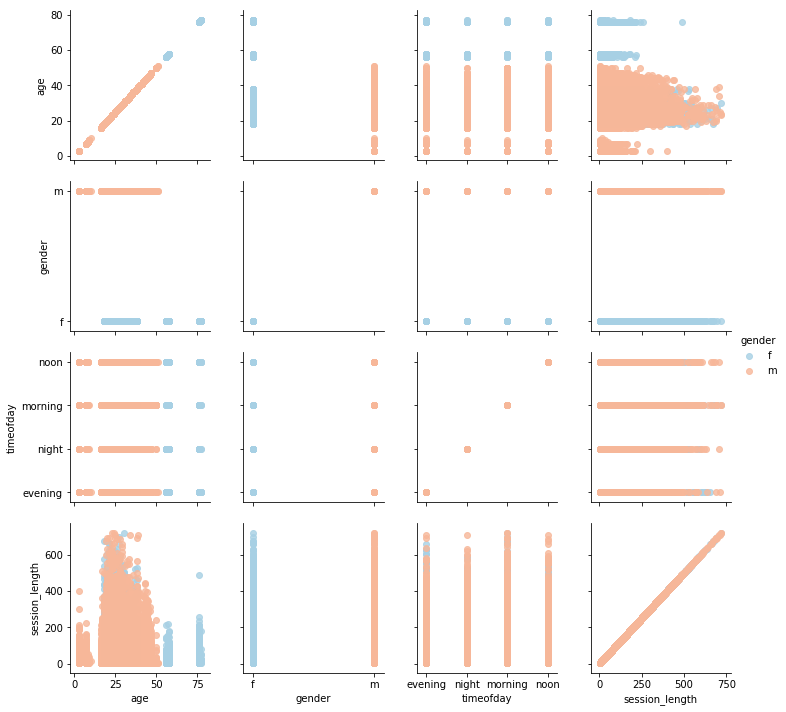

In [165]:
g = sns.PairGrid(plot_df2, vars=['age', 'gender', 'timeofday', 'session_length'],hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

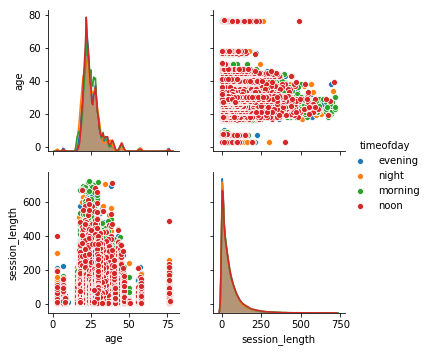

In [160]:

sns.pairplot(plot_df2, hue='timeofday', size=2.5)
plt.show()

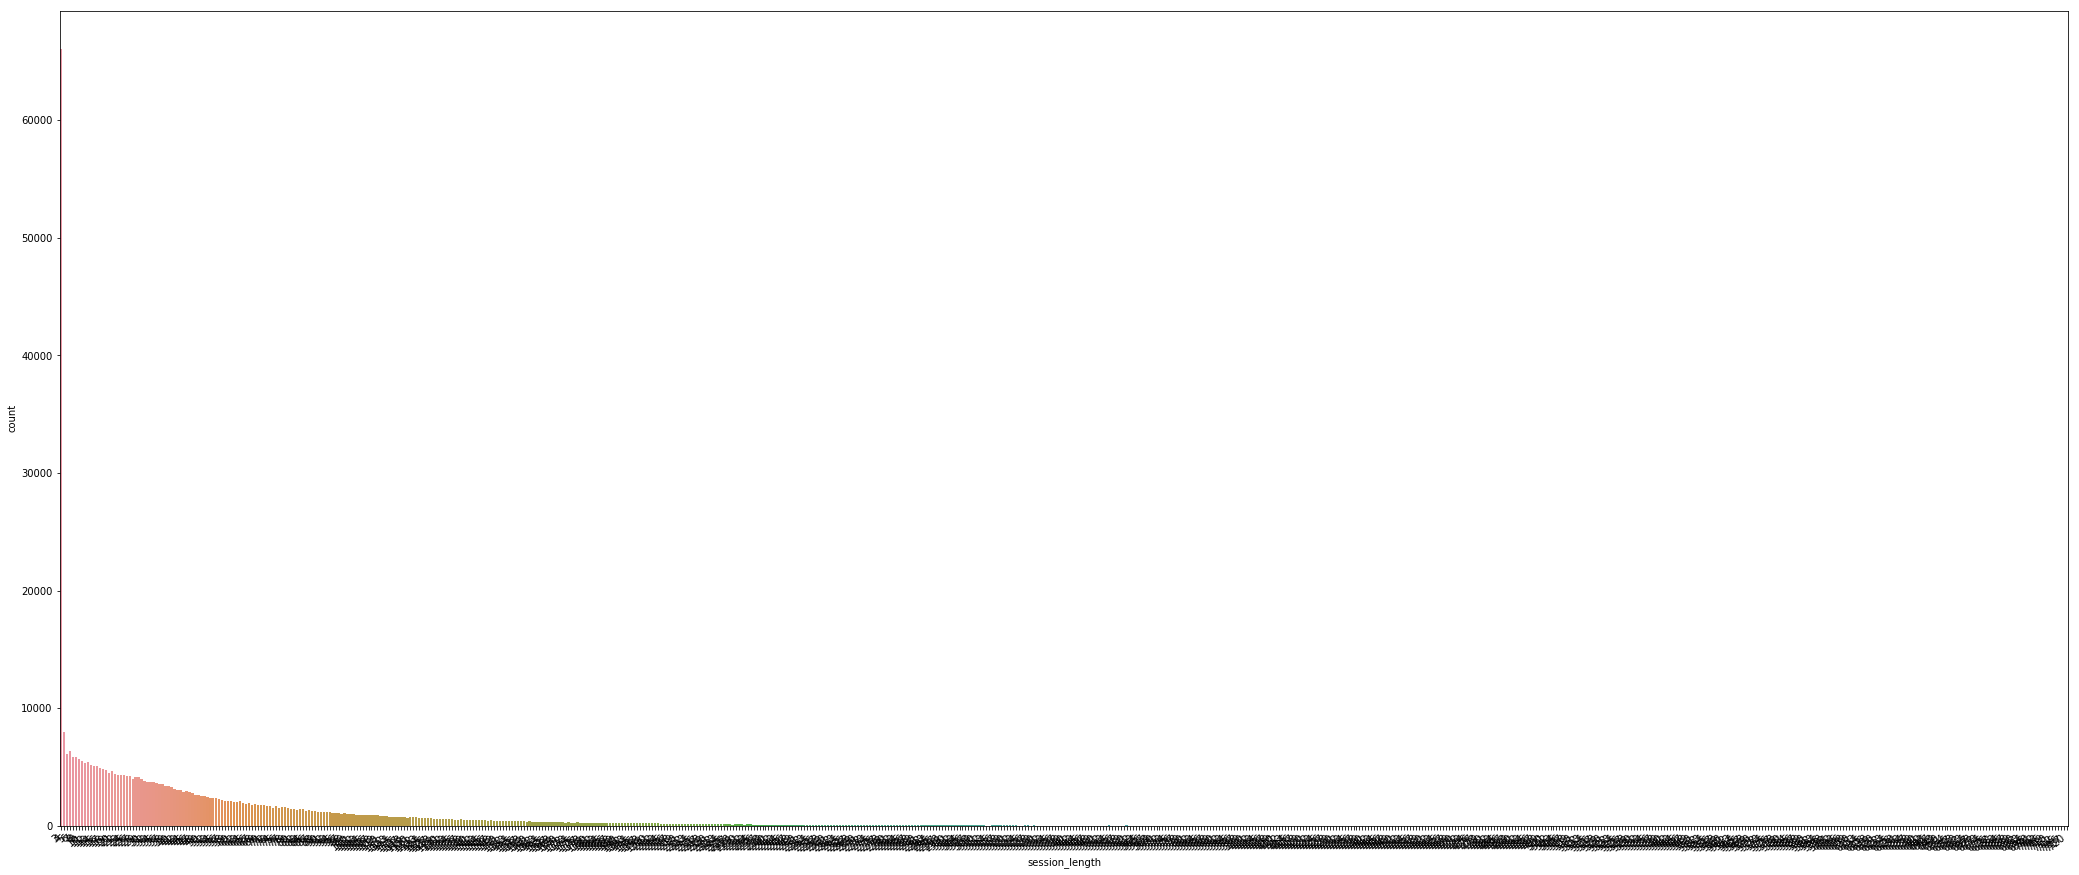

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_df['session_length'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [81]:
user_session_with_window_df = user_session_with_window_df.withColumn('log_sess', round(log(col("session_length")),1)).drop('session_length').withColumnRenamed('log_sess','session_length')

In [82]:
user_session_with_window_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|session_start|window|session_length|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+
|user_000001|     m|null|  Japan|2006-08-13|  sunday   |     noon|        1|   2006-08-13|   589|           5.4|
|user_000001|     m|null|  Japan|2006-08-15|  tuesday  |  morning|        1|   2006-08-15|   591|           5.1|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|  morning|        1|   2006-08-16|   592|           3.8|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|     noon|        2|   2006-08-16|   592|           4.5|
|user_000001|     m|null|  Japan|2006-08-17|  thursday |     noon|        1|   2006-08-17|   593|           4.7|
|user_000001|     m|null|  Japan|2006-08-18|  friday   |  evening|        1|   2006-08-18|   594

In [44]:

#w = Window.partitionBy("userid").orderBy("window").rowsBetween(Window.unboundedPreceding,Window.currentRow)
#(user_session_with_window_df.withColumn("cumSum", sum("session_length").over(w)).show())

In [83]:
plot_log_df = user_session_with_window_df.toPandas()

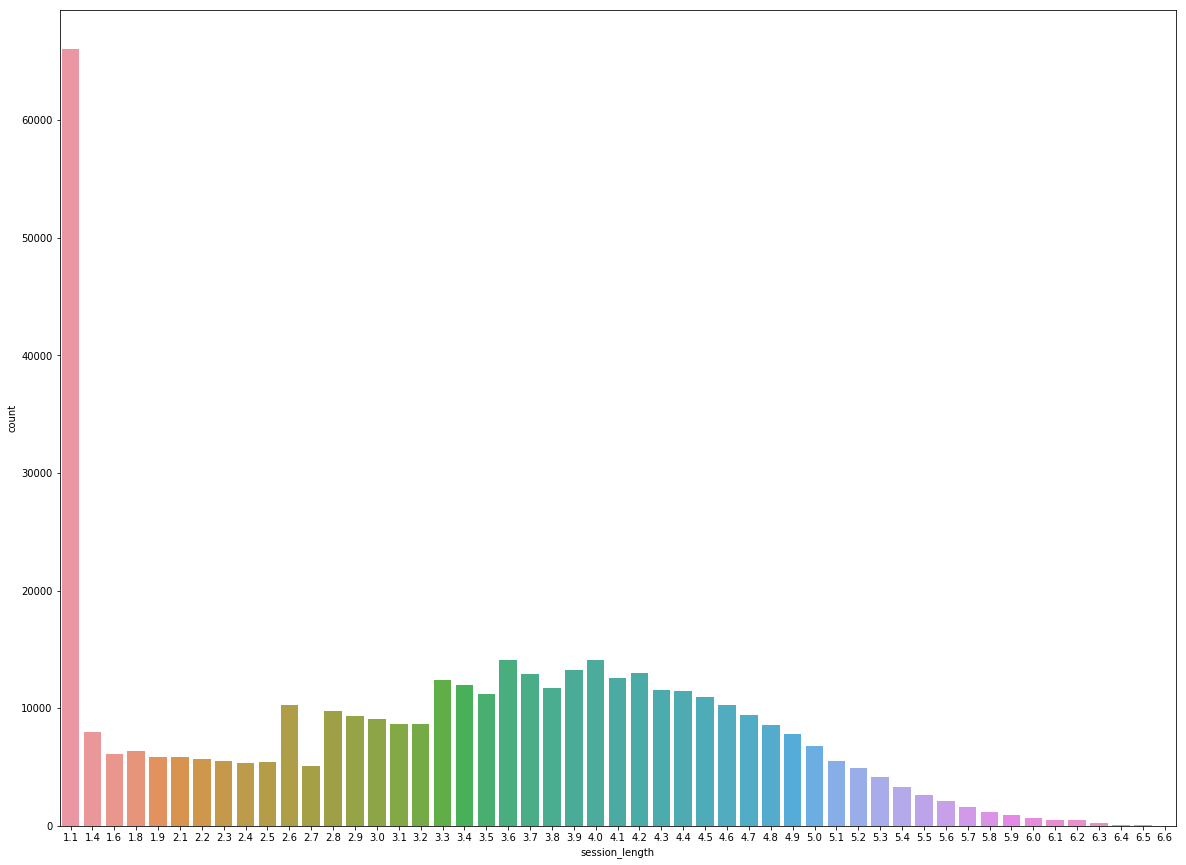

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.countplot(plot_log_df['session_length'])

In [64]:
timeofday    = list([x[0] for x in pd.Series(sess_tod_df.select('timeofday').collect())])
num_sessions = list([y[0] for y in pd.Series(sess_tod_df.select('num_sessions').collect())])

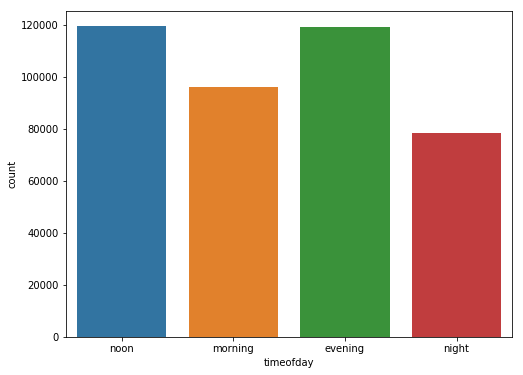

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.countplot(plot_df['timeofday'])

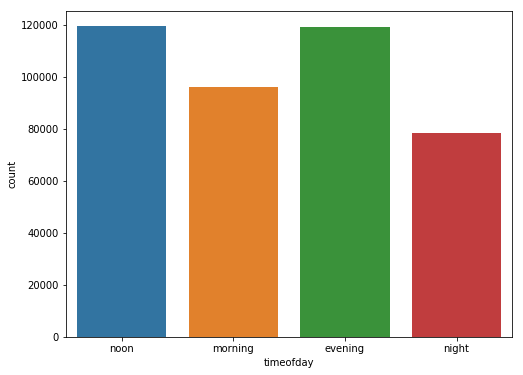

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.countplot(plot_log_df['timeofday'])

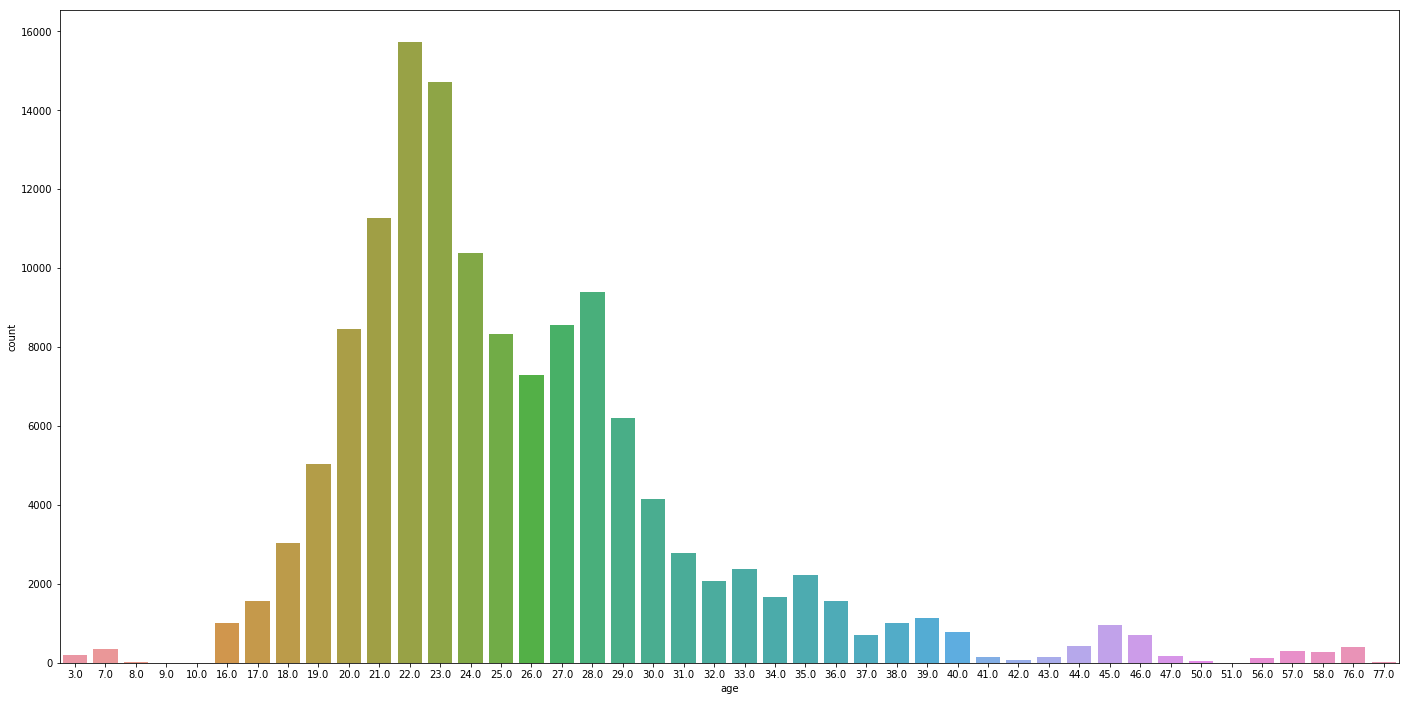

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
sns.countplot(plot_log_df['age'])

In [170]:
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='M'], label='men', shade=True)
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='W'], label='women', shade=True)
#plt.xlabel('split_frac');

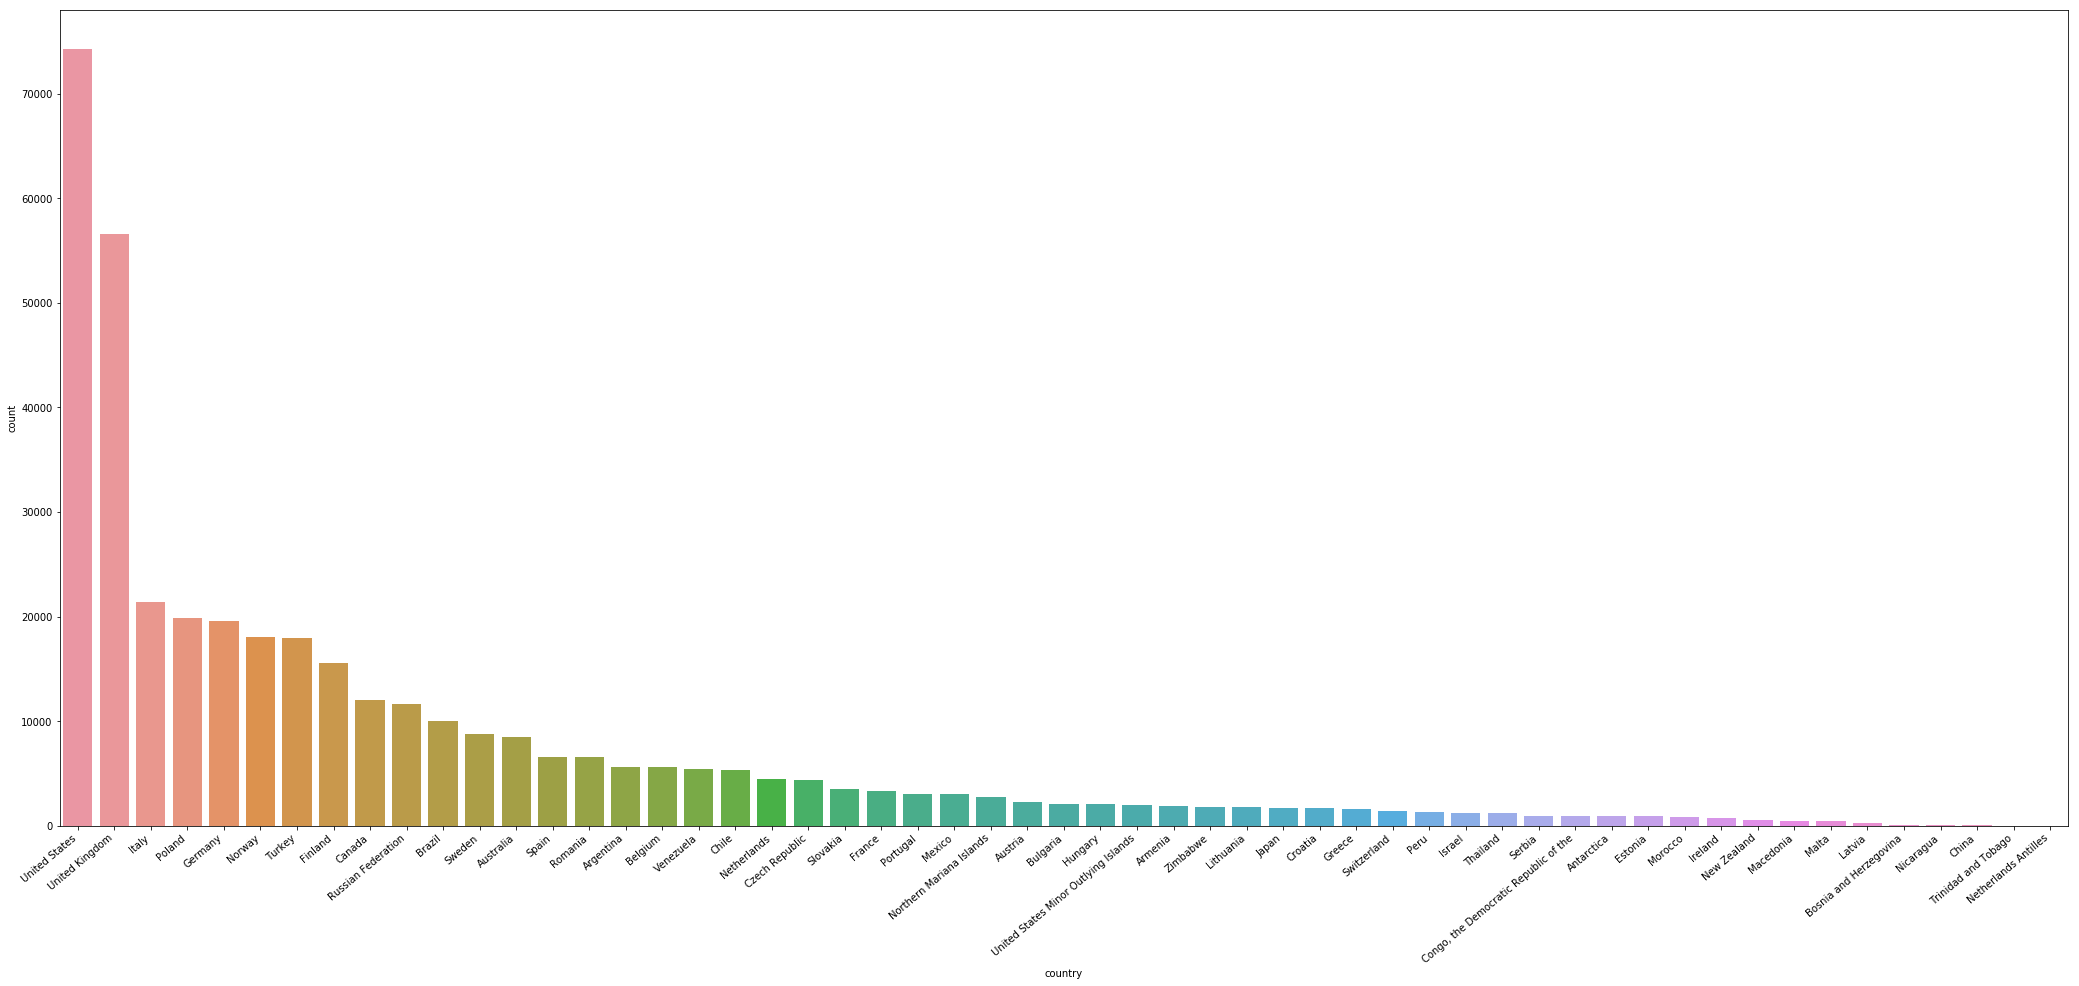

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_log_df['country'], order = plot_log_df['country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

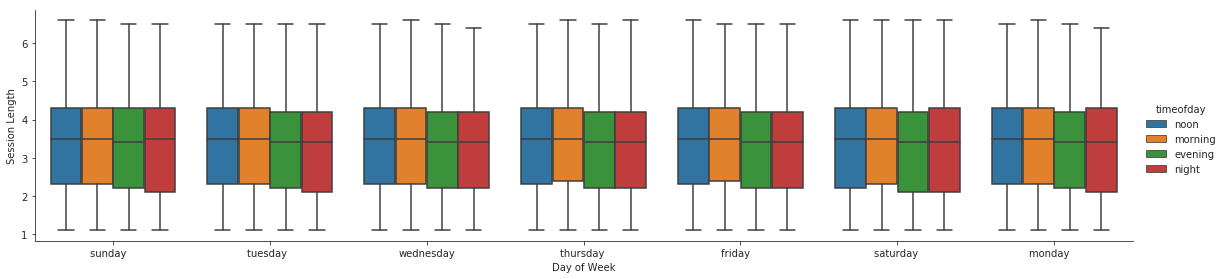

In [173]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "timeofday", data=plot_log_df, kind="box", size=4, aspect=4)
    g.set_axis_labels("Day of Week", "Session Length")

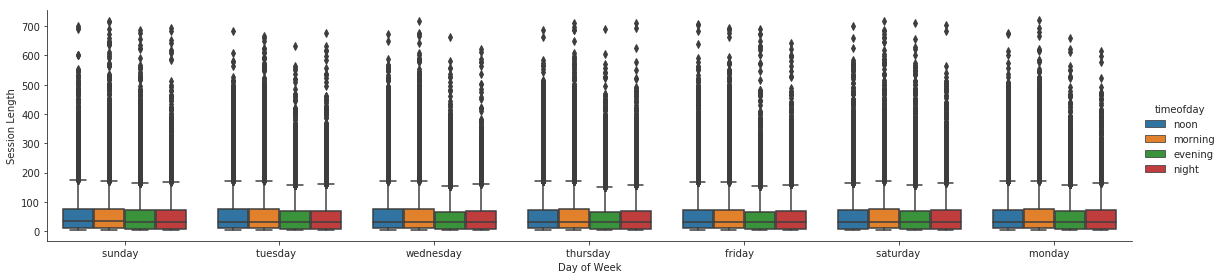

In [174]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "timeofday", data=plot_df, kind="box", size=4, aspect=4)
    g.set_axis_labels("Day of Week", "Session Length")

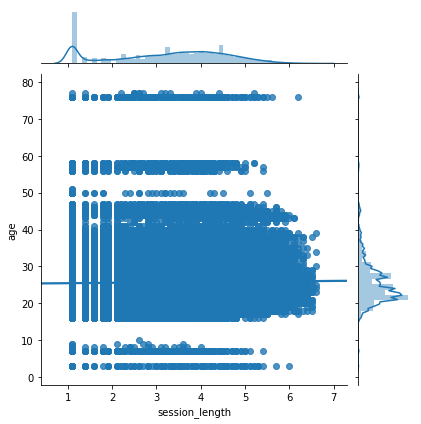

In [150]:
sns.jointplot("session_length", "age", data=plot_log_df, kind='reg');

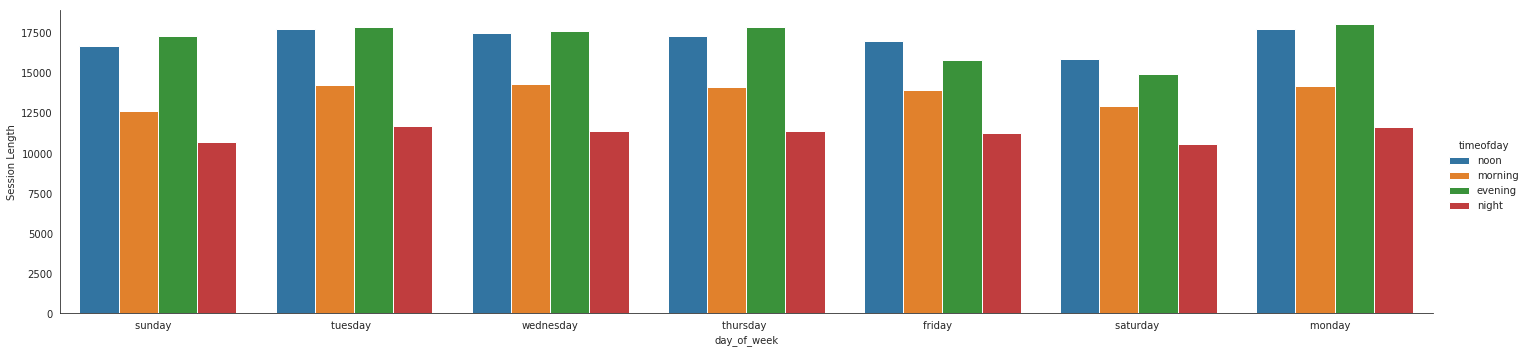

In [152]:
with sns.axes_style('white'):
    g = sns.factorplot("day_of_week", data=plot_log_df, aspect=4.0, kind='count',
                       hue='timeofday')
    g.set_ylabels('Session Length')

In [109]:
data = user_session_with_window_df.select('session_length').rdd.map(lambda row: row.session_length).collect()
data[:5]

[5.4, 5.1, 3.8, 4.5, 4.7]

In [110]:
data = pd.DataFrame(data,columns=['session_length']).iloc[:,0]

In [111]:
data.head()

0    5.4
1    5.1
2    3.8
3    4.5
4    4.7
Name: session_length, dtype: float64

In [175]:
data.describe()

count    909911.000000
mean          3.468112
std           1.437358
min           1.100000
25%           2.500000
50%           3.600000
75%           4.500000
max           9.900000
Name: session_length, dtype: float64

In [112]:
deciles = list(np.percentile(data, np.arange(0, 100, 10)))
deciles

[1.1, 1.1, 1.8, 2.6, 3.1, 3.5, 3.8, 4.1, 4.4, 4.9]

#### Add Quantile Bucketized Column

In [177]:
num_windows = int(user_session_with_window_df.select('session_length').distinct().count())
num_windows

83

In [113]:
num_buckets = 10

In [114]:
session_length_bucketizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="session_length", outputCol="decile", relativeError=0.01, handleInvalid="error")
bucketizer = session_length_bucketizer.fit(user_session_with_window_df)
user_session_with_window_bucketized_df = bucketizer.setHandleInvalid("skip").transform(user_session_with_window_df)
user_session_with_window_bucketized_df.show()


+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|session_start|window|session_length|decile|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+------+
|user_000001|     m|null|  Japan|2006-08-13|  sunday   |     noon|        1|   2006-08-13|   589|           5.4|   9.0|
|user_000001|     m|null|  Japan|2006-08-15|  tuesday  |  morning|        1|   2006-08-15|   591|           5.1|   9.0|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|  morning|        1|   2006-08-16|   592|           3.8|   6.0|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|     noon|        2|   2006-08-16|   592|           4.5|   8.0|
|user_000001|     m|null|  Japan|2006-08-17|  thursday |     noon|        1|   2006-08-17|   593|           4.7|   8.0|
|user_000001|     m|null|  Japan|2006-08

In [115]:
deciles

[1.1, 1.1, 1.8, 2.6, 3.1, 3.5, 3.8, 4.1, 4.4, 4.9]

In [116]:
decile_dict = {1.0:"<5_mins",2.0:"<5_mins",3.0:"<10_mins",4.0:"<20_mins",5.0:"<30_mins",6.0:"<40_mins",7.0:"<1_hour",8.0:"<1.5_hours",9.0:"<2_hours",10.0:">3_hours"}

In [117]:
def get_description(decile):
    try:
        return decile_dict[decile]
    except:
        return None

In [118]:
get_desc = udf(lambda decile: get_description(decile), StringType())

In [119]:
user_session_with_window_bucketized_descr_df = user_session_with_window_bucketized_df.withColumn('description', get_desc(col('decile')))

In [120]:
user_session_with_window_bucketized_descr_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+------+-----------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|session_start|window|session_length|decile|description|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------+------+--------------+------+-----------+
|user_000001|     m|null|  Japan|2006-08-13|  sunday   |     noon|        1|   2006-08-13|   589|           5.4|   9.0|   <2_hours|
|user_000001|     m|null|  Japan|2006-08-15|  tuesday  |  morning|        1|   2006-08-15|   591|           5.1|   9.0|   <2_hours|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|  morning|        1|   2006-08-16|   592|           3.8|   6.0|   <40_mins|
|user_000001|     m|null|  Japan|2006-08-16|  wednesday|     noon|        2|   2006-08-16|   592|           4.5|   8.0| <1.5_hours|
|user_000001|     m|null|  Japan|2006-08-17|  thursday |     noon|        1|

In [121]:
train_data = None
dev_data = None
test_data = None

In [122]:
user_session_with_window_bucketized_descr_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- startdate: date (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- session_start: date (nullable = true)
 |-- window: integer (nullable = true)
 |-- session_length: double (nullable = true)
 |-- decile: double (nullable = true)
 |-- description: string (nullable = true)



In [123]:
def get_train_dev_test_data():
    print("==================================================================================================================")
    print("============================================     CREATE TRAIN/DEV/TEST SETS      =================================")
    print("==================================================================================================================\n\n")
    global train_data, dev_data, test_data
    global user_session_with_window_df

    session_data = user_session_with_window_bucketized_descr_df.select("userid","age","country", "day_of_week", "timeofday", "sessionid","window","description").na.drop()
    categoricalColumns = ["userid","country", "day_of_week", "timeofday"]
    cols = session_data.columns
    stages =[]
    for categoricalCol in categoricalColumns:
        stringIndexer  = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"classVec"])
        stages += [stringIndexer,encoder]
    label_stringIdx = StringIndexer(inputCol="description", outputCol="label")
    stages += [label_stringIdx]
    numericCols = ["age","sessionid","window"]
    assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(session_data)
    session_data = pipelineModel.transform(session_data)
    selectedcols = ["label","features"] + cols
    session_data = session_data.select(selectedcols)
    print("************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************")
    session_data.show(5,False)
    print("************************************           Splitting Train/Test data        *************************************")
    train_data, dev_data, test_data = session_data.randomSplit([0.65, 0.2, 0.15])

In [124]:
get_train_dev_test_data()

============================================     CREATE TRAIN/DEV/TEST SETS      =================================


************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************
+-----+-------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|label|features                                                           |userid     |age|country      |day_of_week|timeofday|sessionid|window|description|
+-----+-------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|0.0  |(203,[47,156,198,200,201,202],[1.0,1.0,1.0,19.0,1.0,742.0])        |user_000009|19 |United States|saturday   |evening  |1        |742   |<5_mins    |
|5.0  |(203,[47,156,195,200,201,202],[1.0,1.0,1.0,19.0,1.0,743.0])        |user_000009|19 |United States|sunday     |night    |1        |

In [125]:
get_train_dev_test_data()

============================================     CREATE TRAIN/DEV/TEST SETS      =================================


************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************
+-----+-------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|label|features                                                           |userid     |age|country      |day_of_week|timeofday|sessionid|window|description|
+-----+-------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|0.0  |(203,[47,156,198,200,201,202],[1.0,1.0,1.0,19.0,1.0,742.0])        |user_000009|19 |United States|saturday   |evening  |1        |742   |<5_mins    |
|5.0  |(203,[47,156,195,200,201,202],[1.0,1.0,1.0,19.0,1.0,743.0])        |user_000009|19 |United States|sunday     |night    |1        |

In [126]:
train_data.show(5,False)

+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|label|features                                                          |userid     |age|country      |day_of_week|timeofday|sessionid|window|description|
+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,1.0,702.0])|user_000089|27 |United States|monday     |noon     |1        |702   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,2.0,632.0])|user_000089|27 |United States|monday     |noon     |2        |632   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,2.0,674.0])|user_000089|27 |United States|monday     |noon     |2        |674   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,3.

In [127]:
dev_data.show(5,False)

+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|label|features                                                          |userid     |age|country      |day_of_week|timeofday|sessionid|window|description|
+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,1.0,422.0])|user_000089|27 |United States|monday     |noon     |1        |422   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,2.0,527.0])|user_000089|27 |United States|monday     |noon     |2        |527   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,4.0,478.0])|user_000089|27 |United States|monday     |noon     |4        |478   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,4.

In [128]:
test_data.show(5,False)

+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|label|features                                                          |userid     |age|country      |day_of_week|timeofday|sessionid|window|description|
+-----+------------------------------------------------------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,3.0,485.0])|user_000089|27 |United States|monday     |noon     |3        |485   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,27.0,5.0,688.0])|user_000089|27 |United States|monday     |noon     |5        |688   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,28.0,1.0,723.0])|user_000089|28 |United States|monday     |noon     |1        |723   |<5_mins    |
|0.0  |(203,[0,156,191,197,200,201,202],[1.0,1.0,1.0,1.0,28.0,2.

### BASELINE DL model with Multinomial Naive Bayes

In [175]:
smoothings  = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [176]:
mnbModel = None

In [177]:
def mnb_classifier(smoothing):
    global mnbModel
    global lr_results
    global train_data, dev_data, test_data
    mnb = NaiveBayes(smoothing=smoothing, modelType="multinomial")
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    mnbModel = mnb.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = mnbModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "age", "country", "day_of_week", "timeofday", "sessionid","window")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(mnbModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    mnb_results.update({smoothing:result})


In [178]:
def eval_mnb_classifier():
    print("###########################################################################################")
    print("############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################")
    print("###########################################################################################")
    print("\tSMOOTHING\tACCURACY")
    for smoothing in smoothings:
        mnb_classifier(smoothing)
        print("\t{}\t\t{}".format(smoothing, mnb_results[smoothing]))
        

In [179]:
mnb_results = dict()

eval_mnb_classifier()

###########################################################################################
############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################
###########################################################################################
	SMOOTHING	ACCURACY
	0.1		0.29217585693
	0.2		0.292101341282
	0.3		0.292213114754
	0.4		0.292287630402
	0.5		0.292287630402
	0.6		0.292287630402
	0.7		0.292250372578
	0.8		0.292250372578
	0.9		0.292399403875
	1.0		0.292250372578


### BASELINE DL model with Multinomial Logistic Regression

In [180]:
lrModel = None

In [181]:
def logistic_classifier(regparam, elasticnetparam):
    global lrModel
    global lr_results
    global train_data, dev_data, test_data
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=regparam, elasticNetParam=elasticnetparam)
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    lrModel = lr.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = lrModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "age", "country", "day_of_week", "timeofday", "sessionid","window")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(lrModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    lr_results.update({elasticnetparam:{regparam:result}})
    #print("MULTINOMIAL LOGISTIC REGRESSION RESULTS:\t{}".format(lr_results))

In [182]:
regparams        = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
elasticnetparams = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [239]:
def eval_mlr_classifier():
    print("###########################################################################################")
    print("###############################         LOGISTIC REGRESSION         #######################")
    print("###########################################################################################")
    print("\tREGPARAM\tELASTICNETPARAM\t\tACCURACY")
    for regparam in regparams:
        for elasticnetparam in elasticnetparams:
            logistic_classifier(regparam, elasticnetparam)
            print("\t{}\t\t\t{}\t\t{}".format(regparam, elasticnetparam,lr_results))
        

In [240]:
lr_results = {}
eval_mlr_classifier()

###########################################################################################
###############################         LOGISTIC REGRESSION         #######################
###########################################################################################
	REGPARAM	ELASTICNETPARAM		ACCURACY
	0.1			0.1		{0.1: {0.1: 0.29195230998509686}}
	0.1			0.2		{0.2: {0.1: 0.28759314456035767}, 0.1: {0.1: 0.29195230998509686}}
	0.1			0.3		{0.3: {0.1: 0.28759314456035767}, 0.2: {0.1: 0.28759314456035767}, 0.1: {0.1: 0.29195230998509686}}
	0.1			0.4		{0.4: {0.1: 0.28759314456035767}, 0.3: {0.1: 0.28759314456035767}, 0.2: {0.1: 0.28759314456035767}, 0.1: {0.1: 0.29195230998509686}}
	0.1			0.5		{0.4: {0.1: 0.28759314456035767}, 0.5: {0.1: 0.28759314456035767}, 0.3: {0.1: 0.28759314456035767}, 0.2: {0.1: 0.28759314456035767}, 0.1: {0.1: 0.29195230998509686}}
	0.1			0.6		{0.5: {0.1: 0.28759314456035767}, 0.2: {0.1: 0.28759314456035767}, 0.4: {0.1: 0.28759314456035767}, 0.6: {0.1: 0.287

	0.3			0.9		{0.5: {0.3: 0.28759314456035767}, 1.0: {0.2: 0.28759314456035767}, 0.4: {0.3: 0.28759314456035767}, 0.2: {0.3: 0.28759314456035767}, 0.1: {0.3: 0.28759314456035767}, 0.3: {0.3: 0.28759314456035767}, 0.6: {0.3: 0.28759314456035767}, 0.8: {0.3: 0.28759314456035767}, 0.9: {0.3: 0.28759314456035767}, 0.7: {0.3: 0.28759314456035767}}
	0.3			1.0		{0.5: {0.3: 0.28759314456035767}, 1.0: {0.3: 0.28759314456035767}, 0.4: {0.3: 0.28759314456035767}, 0.2: {0.3: 0.28759314456035767}, 0.1: {0.3: 0.28759314456035767}, 0.3: {0.3: 0.28759314456035767}, 0.6: {0.3: 0.28759314456035767}, 0.8: {0.3: 0.28759314456035767}, 0.9: {0.3: 0.28759314456035767}, 0.7: {0.3: 0.28759314456035767}}
	0.4			0.1		{0.5: {0.3: 0.28759314456035767}, 1.0: {0.3: 0.28759314456035767}, 0.4: {0.3: 0.28759314456035767}, 0.2: {0.3: 0.28759314456035767}, 0.1: {0.4: 0.28759314456035767}, 0.3: {0.3: 0.28759314456035767}, 0.6: {0.3: 0.28759314456035767}, 0.8: {0.3: 0.28759314456035767}, 0.9: {0.3: 0.28759314456035767}, 0.7:

	0.6			0.3		{0.5: {0.5: 0.28759314456035767}, 1.0: {0.5: 0.28759314456035767}, 0.4: {0.5: 0.28759314456035767}, 0.2: {0.6: 0.28759314456035767}, 0.1: {0.6: 0.28759314456035767}, 0.3: {0.6: 0.28759314456035767}, 0.6: {0.5: 0.28759314456035767}, 0.8: {0.5: 0.28759314456035767}, 0.9: {0.5: 0.28759314456035767}, 0.7: {0.5: 0.28759314456035767}}
	0.6			0.4		{0.5: {0.5: 0.28759314456035767}, 1.0: {0.5: 0.28759314456035767}, 0.4: {0.6: 0.28759314456035767}, 0.2: {0.6: 0.28759314456035767}, 0.1: {0.6: 0.28759314456035767}, 0.3: {0.6: 0.28759314456035767}, 0.6: {0.5: 0.28759314456035767}, 0.8: {0.5: 0.28759314456035767}, 0.9: {0.5: 0.28759314456035767}, 0.7: {0.5: 0.28759314456035767}}
	0.6			0.5		{0.5: {0.6: 0.28759314456035767}, 1.0: {0.5: 0.28759314456035767}, 0.4: {0.6: 0.28759314456035767}, 0.2: {0.6: 0.28759314456035767}, 0.1: {0.6: 0.28759314456035767}, 0.3: {0.6: 0.28759314456035767}, 0.6: {0.5: 0.28759314456035767}, 0.8: {0.5: 0.28759314456035767}, 0.9: {0.5: 0.28759314456035767}, 0.7:

	0.8			0.7		{0.5: {0.8: 0.28759314456035767}, 1.0: {0.7: 0.28759314456035767}, 0.4: {0.8: 0.28759314456035767}, 0.2: {0.8: 0.28759314456035767}, 0.1: {0.8: 0.28759314456035767}, 0.3: {0.8: 0.28759314456035767}, 0.6: {0.8: 0.28759314456035767}, 0.8: {0.7: 0.28759314456035767}, 0.9: {0.7: 0.28759314456035767}, 0.7: {0.8: 0.28759314456035767}}
	0.8			0.8		{0.5: {0.8: 0.28759314456035767}, 1.0: {0.7: 0.28759314456035767}, 0.4: {0.8: 0.28759314456035767}, 0.2: {0.8: 0.28759314456035767}, 0.1: {0.8: 0.28759314456035767}, 0.3: {0.8: 0.28759314456035767}, 0.6: {0.8: 0.28759314456035767}, 0.8: {0.8: 0.28759314456035767}, 0.9: {0.7: 0.28759314456035767}, 0.7: {0.8: 0.28759314456035767}}
	0.8			0.9		{0.5: {0.8: 0.28759314456035767}, 1.0: {0.7: 0.28759314456035767}, 0.4: {0.8: 0.28759314456035767}, 0.2: {0.8: 0.28759314456035767}, 0.1: {0.8: 0.28759314456035767}, 0.3: {0.8: 0.28759314456035767}, 0.6: {0.8: 0.28759314456035767}, 0.8: {0.8: 0.28759314456035767}, 0.9: {0.8: 0.28759314456035767}, 0.7:

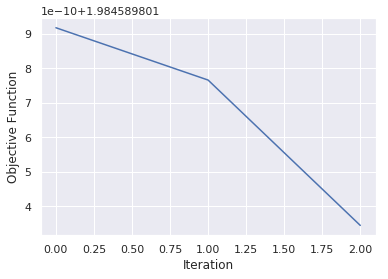

In [241]:
trainingSummary = lrModel.summary

objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

#### Examples from: https://runawayhorse001.github.io/LearningApacheSpark/classification.html

In [242]:
predictions = lrModel.transform(dev_data)
predictions.select("features","label","prediction").show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(203,[0,156,191,1...|  0.0|       0.0|
|(203,[0,156,191,1...|  0.0|       0.0|
|(203,[0,156,191,1...|  0.0|       0.0|
|(203,[0,156,191,1...|  0.0|       0.0|
|(203,[0,156,191,1...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



In [243]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.712407


In [244]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [245]:
predictions.show()

+-----+--------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+--------------------+--------------------+----------+
|label|            features|     userid|age|      country|day_of_week|timeofday|sessionid|window|description|       rawPrediction|         probability|prediction|
+-----+--------------------+-----------+---+-------------+-----------+---------+---------+------+-----------+--------------------+--------------------+----------+
|  0.0|(203,[0,156,191,1...|user_000089| 27|United States|  monday   |     noon|        1|   422|    <5_mins|[0.90646756855605...|[0.28613007606937...|       0.0|
|  0.0|(203,[0,156,191,1...|user_000089| 27|United States|  monday   |     noon|        2|   527|    <5_mins|[0.90646756855605...|[0.28613007606937...|       0.0|
|  0.0|(203,[0,156,191,1...|user_000089| 27|United States|  monday   |     noon|        4|   478|    <5_mins|[0.90646756855605...|[0.28613007606937...|       0.0|
|  0.0|(203,[0,156,191

In [246]:
class_temp  = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp

,label,count
0,0.0,7719
1,1.0,3272
2,2.0,2862
3,3.0,2772
4,4.0,2680
5,5.0,2568
6,6.0,2500
7,7.0,2467


In [247]:
class_names = class_temp['label']

In [248]:
class_names

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    7.0
Name: label, dtype: float64

### Manually Create Confusion Matrix

In [249]:
df = predictions.select('label','prediction')
df.show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [250]:
print("\tLABEL\tLabels\tPredictions")
for label in class_names:
    num_labels = df[df['label'] == label].count()
    num_correct_preds = df[(df['label'] == label) & (df['prediction'] == label)].count()
    print("\t{}\t{}\t{}".format(label,num_labels,num_correct_preds))

	LABEL	Labels	Predictions
	0.0	7719	7719
	1.0	3272	0
	2.0	2862	0
	3.0	2772	0
	4.0	2680	0
	5.0	2568	0
	6.0	2500	0
	7.0	2467	0


In [251]:
predictions_rdd = predictions.select('prediction','label').rdd.map(tuple)

In [252]:
predictions_rdd.take(5)

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

In [253]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictions_rdd.map(tuple))

In [254]:


# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
#labels = data.map(lambda lp: lp.label).distinct().collect()
labels = class_names
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.28759314456
Recall = 0.28759314456
F1 Score = 0.28759314456
Class 0.0 precision = 0.28759314456
Class 0.0 recall = 1.0
Class 0.0 F1 Measure = 0.44671431465
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Class 3.0 precision = 0.0
Class 3.0 recall = 0.0
Class 3.0 F1 Measure = 0.0
Class 4.0 precision = 0.0
Class 4.0 recall = 0.0
Class 4.0 F1 Measure = 0.0
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
Class 6.0 precision = 0.0
Class 6.0 recall = 0.0
Class 6.0 F1 Measure = 0.0
Class 7.0 precision = 0.0
Class 7.0 recall = 0.0
Class 7.0 F1 Measure = 0.0
Weighted recall = 0.28759314456
Weighted precision = 0.0827098167981
Weighted F(1) Score = 0.12847197447
Weighted F(0.5) Score = 0.0964525014495
Weighted false positive rate = 0.28759314456


In [255]:
m = metrics.confusionMatrix()

In [256]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 

import seaborn as sns
sns.set() 


def display_cm(m):
  a = m.toArray().astype(np.float)
  row_sums = a.sum(axis=1)
  percentage_matrix = a.astype(np.float) / row_sums[:, np.newaxis]
  print(percentage_matrix)
  plt.figure(figsize=(3, 3))
  sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
  plt.title('Confusion Matrix');

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


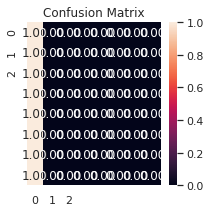

In [257]:
display_cm(m)

### BASELINE DL model with an generic MLP Classifier

In [258]:
train_data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- window: integer (nullable = true)
 |-- description: string (nullable = true)



In [259]:
def mlp_classifier():
    print("###########################################################################################")
    print("##################################       MLP CLASSIFIER      ##############################")
    print("###########################################################################################")
    global mlp_results
    global train_data, dev_data, test_data
    layer_1 = train_data.schema["features"].metadata["ml_attr"]["num_attrs"]
    layer_2 = layer_1*4
    layer_3 = int(layer_2/2)
    layer_4 = num_buckets
    layers = [layer_1, layer_2, layer_3, layer_4]
    print("LAYERS: \t{}".format(layers))
    print("---------------------------------  Training MLP Model        ------------------------------")
    trainer = MultilayerPerceptronClassifier(maxIter=5, layers=layers, blockSize=128)
    print("---------------------------------  Fitting Model to TRAIN    ------------------------------")
    mlp_model = trainer.fit (train_data)        
    print("---------------------------------  Testing Model against DEV ------------------------------")
    predictions = mlp_model.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "age", "country", "day_of_week", "timeofday", "sessionid", "window")
    print("evaluator = MulticlassClassificationEvaluator().....")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    print("result = evaluator.evaluate(mlp_model.transform(dev_data))")
    result = evaluator.evaluate(mlp_model.transform(dev_data))
    mlp_results.append(result)
    print("MLP CLASSIFIER RESULTS:\t{}".format(mlp_results))

In [260]:
mlp_results = []
mlp_classifier()

###########################################################################################
##################################       MLP CLASSIFIER      ##############################
###########################################################################################
LAYERS: 	[203, 812, 406, 10]
---------------------------------  Training MLP Model        ------------------------------
---------------------------------  Fitting Model to TRAIN    ------------------------------
---------------------------------  Testing Model against DEV ------------------------------
evaluator = MulticlassClassificationEvaluator().....
result = evaluator.evaluate(mlp_model.transform(dev_data))
MLP CLASSIFIER RESULTS:	[0.28759314456035767]


### BASELINE Model with Decision Tree Classifier

In [261]:
dt_results = []
maxBins = 100


In [262]:
def decisionTree_classifier(max_depth):
    global dt_results
    global train_data, dev_data, test_data
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=max_depth, maxBins=100)
    dtModel = dt.fit(train_data)
    #print("numNodes = ", dtModel.numNodes)
    #print("depth = ", dtModel.depth)
    evaluator = MulticlassClassificationEvaluator().setMetricName ('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    #print("result = evaluator.evaluate(dfModel.transform(dev_data))")
    result = evaluator.evaluate(dtModel.transform(dev_data))
    #print("dt_results.append(result)")
    dt_results.append(result)
    #print("DECISION TREE CLASSIFIER RESULTS:\t{}".format(dt_results))

In [263]:
def eval_dt_classifier():
    print("###########################################################################################")
    print("###############################          DECISION TREE              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    global rf_results
    for max_tree_depth in max_tree_depths:
        decisionTree_classifier(max_tree_depth)
        print("\t{}".format(rf_results))
        

In [264]:
max_tree_depths = [1,2,3,4,5,6,7,8,9,10]

In [265]:
rf_results = []
eval_dt_classifier()

###########################################################################################
###############################          DECISION TREE              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
	[]
	[]
	[]
	[]
	[]
	[]
	[]
	[]
	[]
	[]


### BASELINE Model with RandomForest Classifier

In [266]:
rfModel = None
def randomForest_classifier(num_tree, max_tree_depth):
    global rf_results
    global rfModel
    global train_data, dev_data, test_data
    #rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=20, maxBins=100)
    rf = RandomForestClassifier(numTrees=num_tree, featureSubsetStrategy="auto", impurity="gini", labelCol="label", featuresCol="features", maxDepth=max_tree_depth, maxBins=100)
    
    #print("---------------------------------  Fitting Model to Train     ------------------------------")
    rfModel = rf.fit(train_data)
    #print("---------------------------------  Transforming Dev           ------------------------------")
    predictions = rfModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "age", "country", "day_of_week", "timeofday", "sessionid","window")
    #print("---------------------------------     Evaluating Model        ------------------------------")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    result = evaluator.evaluate(rfModel.transform(dev_data))
    #print("---------------------------------  Summarizing Results        ------------------------------")
    rf_results.update({num_tree:{max_tree_depth:result}})
    #print("RANDOM FOREST CLASSIFIER RESULTS:\t{}".format(rf_results))

In [267]:
def eval_rf_classifier():
    print("###########################################################################################")
    print("###############################          RANDOM FOREST              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    for num_tree in num_trees:
        for max_tree_depth in max_tree_depths:
            randomForest_classifier(num_tree, max_tree_depth)
            print("\t{}\t\t\t{}\t\t{}".format(num_tree, max_tree_depth,rf_results[num_tree][max_tree_depth]))
        

In [268]:
max_tree_depths = [1,2,3,4,5,6,7,8,9,10]
num_trees       = [10,20,30,40,50,60,70,80,100]

In [269]:
rf_results = dict()

eval_rf_classifier()

###########################################################################################
###############################          RANDOM FOREST              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
	10			1		0.28759314456
	10			2		0.288152011923
	10			3		0.291356184799
	10			4		0.29217585693
	10			5		0.29217585693
	10			6		0.292436661699
	10			7		0.292511177347
	10			8		0.292995529061
	10			9		0.294076005961
	10			10		0.295044709389
	20			1		0.28759314456
	20			2		0.28759314456
	20			3		0.291952309985
	20			4		0.291952309985
	20			5		0.291952309985
	20			6		0.291952309985
	20			7		0.291952309985
	20			8		0.293479880775
	20			9		0.293889716841
	20			10		0.293740685544
	30			1		0.28759314456
	30			2		0.28759314456
	30			3		0.288859910581
	30			4		0.291952309985
	30			5		0.291915052161
	30			6		0.291915052161
	30			7		0.291915052161
	30			8		0.293181818182
	30			9		0.2932935916

### SCIKIT LEARN

In [270]:
# Import SciKitLearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, MultiTaskLassoCV, LassoLarsCV, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV as CV

# Other packages
import time
import numpy as np
import pandas as pd
import re
import scipy as sp
import matplotlib.pyplot as plt
from numpy import concatenate
from pandas import DataFrame, Series, read_csv, scatter_matrix

# Install packages
!pip install keras

# Weighted Mean Absolute Error Function
def weighted_mean_abs_err(y_true, y_pred, weights):
  return np.mean(np.mean(np.abs(y_true - y_pred), axis=1) * weights)

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [271]:
!head /data_data/session_length/usersessions-with-ids-jayashree.csv

In [272]:
userSession_df = None

In [273]:

def import_sessionData():
    print("==================================================================================================================")
    print("========================================    IMPORTING USER SESSION DATA     ======================================")
    print("==================================================================================================================\n\n")
    global userSession_df
    
    sessionSchema = StructType([
        StructField('userid', StringType(), True),\
        StructField('gender', IntegerType(), True),\
        StructField('age', IntegerType(), True),\
        StructField('country', IntegerType(), True),\
        StructField('startdate', DateType(), True),\
        StructField('day_of_week', IntegerType(), True),\
        StructField('timeofday', IntegerType(), True),\
        StructField('sessionid', IntegerType(), True),\
        StructField('session_start', StringType(), True),\
        StructField('session_length', IntegerType(), True),\
        ])
    
    userSession_df = spark.read.format('csv').schema(sessionSchema).option('header',True).load('/data_data/session_length/usersessions-with-ids-jayashree.csv')
    


In [274]:
import_sessionData()

========================================    IMPORTING USER SESSION DATA     ======================================




In [275]:
userSession_df.show(5,False)

+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+
|userid     |gender|age |country|startdate |day_of_week|timeofday|sessionid|session_start      |session_length|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+
|user_000001|1     |null|32     |2006-08-13|0          |2        |1        |2006-08-13 13:59:20|230           |
|user_000001|1     |null|32     |2006-08-15|2          |1        |1        |2006-08-15 12:27:51|170           |
|user_000001|1     |null|32     |2006-08-16|3          |1        |1        |2006-08-16 10:27:16|43            |
|user_000001|1     |null|32     |2006-08-16|3          |2        |2        |2006-08-16 13:43:02|86            |
|user_000001|1     |null|32     |2006-08-17|4          |2        |1        |2006-08-17 13:33:27|115           |
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------

In [276]:
def get_flat_date(date):
    return str(date).replace("-","")

In [277]:
flatten_date = udf(lambda date: get_flat_date(date), IntegerType())

In [278]:
userSession_df = userSession_df.withColumn('start_date',flatten_date(col('startdate')))

In [279]:
userSession_df.show(5)

+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+----------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|      session_start|session_length|start_date|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+----------+
|user_000001|     1|null|     32|2006-08-13|          0|        2|        1|2006-08-13 13:59:20|           230|      null|
|user_000001|     1|null|     32|2006-08-15|          2|        1|        1|2006-08-15 12:27:51|           170|      null|
|user_000001|     1|null|     32|2006-08-16|          3|        1|        1|2006-08-16 10:27:16|            43|      null|
|user_000001|     1|null|     32|2006-08-16|          3|        2|        2|2006-08-16 13:43:02|            86|      null|
|user_000001|     1|null|     32|2006-08-17|          4|        2|        1|2006-08-17 13:33:27|           115|      null|
+-----------+---

In [280]:
userSession_with_window_df = userSession_df.withColumn('window', time_delta_udf(col("startdate"), lit(day_zero).cast('date')))

In [281]:
userSession_with_window_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+----------+------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|      session_start|session_length|start_date|window|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+--------------+----------+------+
|user_000001|     1|null|     32|2006-08-13|          0|        2|        1|2006-08-13 13:59:20|           230|      null|   589|
|user_000001|     1|null|     32|2006-08-15|          2|        1|        1|2006-08-15 12:27:51|           170|      null|   591|
|user_000001|     1|null|     32|2006-08-16|          3|        1|        1|2006-08-16 10:27:16|            43|      null|   592|
|user_000001|     1|null|     32|2006-08-16|          3|        2|        2|2006-08-16 13:43:02|            86|      null|   592|
|user_000001|     1|null|     32|2006-08-17|          4|        2|        1|2006-08-17 13:

In [282]:
userSession_with_window_df = userSession_with_window_df.withColumn('log_sess', round(log(col("session_length")),1)).drop('session_length').withColumnRenamed('log_sess','session_length')

In [283]:
userSession_with_window_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+----------+------+--------------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|      session_start|start_date|window|session_length|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+----------+------+--------------+
|user_000001|     1|null|     32|2006-08-13|          0|        2|        1|2006-08-13 13:59:20|      null|   589|           5.4|
|user_000001|     1|null|     32|2006-08-15|          2|        1|        1|2006-08-15 12:27:51|      null|   591|           5.1|
|user_000001|     1|null|     32|2006-08-16|          3|        1|        1|2006-08-16 10:27:16|      null|   592|           3.8|
|user_000001|     1|null|     32|2006-08-16|          3|        2|        2|2006-08-16 13:43:02|      null|   592|           4.5|
|user_000001|     1|null|     32|2006-08-17|          4|        2|        1|2006-08-17 13:

In [284]:
get_user_num = udf(lambda userid: int(userid.split('_')[1].lstrip('0')))
userSession_with_window_df = userSession_with_window_df.withColumn('usernum', get_user_num(col('userid'))) 
userSession_with_window_df.show()

+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+----------+------+--------------+-------+
|     userid|gender| age|country| startdate|day_of_week|timeofday|sessionid|      session_start|start_date|window|session_length|usernum|
+-----------+------+----+-------+----------+-----------+---------+---------+-------------------+----------+------+--------------+-------+
|user_000001|     1|null|     32|2006-08-13|          0|        2|        1|2006-08-13 13:59:20|      null|   589|           5.4|      1|
|user_000001|     1|null|     32|2006-08-15|          2|        1|        1|2006-08-15 12:27:51|      null|   591|           5.1|      1|
|user_000001|     1|null|     32|2006-08-16|          3|        1|        1|2006-08-16 10:27:16|      null|   592|           3.8|      1|
|user_000001|     1|null|     32|2006-08-16|          3|        2|        2|2006-08-16 13:43:02|      null|   592|           4.5|      1|
|user_000001|     1|null|     32|2

In [285]:
data = userSession_with_window_df.toPandas()

In [286]:
data[:10]

,userid,gender,age,country,startdate,day_of_week,timeofday,sessionid,session_start,start_date,window,session_length,usernum
0,user_000001,1.0,NaN,32,2006-08-13,0,2,1,2006-08-13 13:59:20,NaN,589,5.4,1
1,user_000001,1.0,NaN,32,2006-08-15,2,1,1,2006-08-15 12:27:51,NaN,591,5.1,1
2,user_000001,1.0,NaN,32,2006-08-16,3,1,1,2006-08-16 10:27:16,NaN,592,3.8,1
3,user_000001,1.0,NaN,32,2006-08-16,3,2,2,2006-08-16 13:43:02,NaN,592,4.5,1
4,user_000001,1.0,NaN,32,2006-08-17,4,2,1,2006-08-17 13:33:27,NaN,593,4.7,1
5,user_000001,1.0,NaN,32,2006-08-18,5,3,1,2006-08-18 19:09:27,NaN,594,3.8,1
6,user_000001,1.0,NaN,32,2006-08-19,6,1,1,2006-08-19 12:26:52,NaN,595,4.7,1
7,user_000001,1.0,NaN,32,2006-08-20,0,2,1,2006-08-20 13:01:54,NaN,596,4.7,1
8,user_000001,1.0,NaN,32,2006-08-21,1,4,1,2006-08-21 03:36:08,NaN,597,2.9,1
9,user_000001,1.0,NaN,32,2006-08-21,1,4,2,2006-08-21 04:33:20,NaN,597,3.0,1


In [287]:
model_df = data[['userid','gender','country','window','day_of_week','timeofday','sessionid','usernum','session_length']].set_index(['userid']) 

In [288]:
model_df.head()

,gender,country,window,day_of_week,timeofday,sessionid,usernum,session_length
userid,,,,,,,,
user_000001,1.0,32,589,0,2,1,1,5.4
user_000001,1.0,32,591,2,1,1,1,5.1
user_000001,1.0,32,592,3,1,1,1,3.8
user_000001,1.0,32,592,3,2,2,1,4.5
user_000001,1.0,32,593,4,2,1,1,4.7


### DECISION TREE

### LSTM

In [290]:
model_df[:5]

,gender,country,window,day_of_week,timeofday,sessionid,usernum,session_length
userid,,,,,,,,
user_000001,1.0,32,589,0,2,1,1,5.4
user_000001,1.0,32,591,2,1,1,1,5.1
user_000001,1.0,32,592,3,1,1,1,3.8
user_000001,1.0,32,592,3,2,2,1,4.5
user_000001,1.0,32,593,4,2,1,1,4.7
